### Notebook for cleaning merged dataset from DiagUsagePowerBI_merged.xlsx


In [221]:
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import pandas as pd
import numpy as np

In [222]:
#import dataset with all dates merged to a single table
diag_usage_df = pd.read_excel('../Data/DiagUsagePowerBI_merged.xlsx', sheet_name='connect_system')

In [223]:
diag_usage_df.sample(5)

,timestamp,siteId,billable_status,OsName,client_OS,vin,year,make,model,system,veh_desc,vci_version,scan_method,batt_voltage,result_string,result,state,city,product_type,postal_code
137755,2025-02-05 22:34:34.756,87302,BILL,Windows,Windows 10.0.19045,5FPYK3F7XHB,2017.0,Honda,Ridgeline,Anti-Lock Brakes,2017 Honda Ridgeline Anti-Lock Brakes,22.1.2418.1,quick_scan,13.86,Successfully connected to vehicle,success,MO,JOPLIN,COLLISION,64801-4908
144352,2025-01-30 20:49:58.634,352624,BILL,Android,Android 11,5FNRL6H72KB,2019.0,Honda,Odyssey,Enhanced Powertrain,2019 Honda Odyssey Enhanced Powertrain,21.2.2323.1,quick_scan,11.72,Successfully connected to vehicle,success,IN,Indianapolis,COLLISION,46240-3738
99272,2024-10-19 01:47:35.834,36259,BILL,Android,Android 12,1N4AL3AP2DN,2013.0,Altima,Altima,Enhanced Powertrain CAN,2013 Nissan Altima Enhanced Powertrain CAN,21.2.2323.1,quick_scan,NaN,Successfully connected to vehicle,success,BC,Surrey,COLLISION,V3W 6Y5
64958,2024-11-25 20:34:55.748,357990,BILL,Android,Android 10,1FM5K7F87JG,2018.0,Ford,Explorer,Enhanced Powertrain CAN,2018 Ford Explorer Enhanced Powertrain CAN,22.3.2439.2,quick_scan,12.19,Successfully connected to vehicle,success,CA,SANTA MARIA,COLLISION,93454-5126
56049,2024-11-25 17:11:54.639,618180,BILL,Android,Android 14,3VWW57AU8KM,2019.0,Volkswagen,Golf,01 - Engine,2019 Volkswagen Golf 01 - Engine,22.1.2418.1,manual scan,14.66,Successfully connected to vehicle,success,QC,CHICOUTIMI,COLLISION,G7G 1T4


In [224]:
#we are only interested in billable customers. Drop all rows where billable_status is not 'Bill' and drop the column
diag_usage_df = diag_usage_df[diag_usage_df['billable_status'] == 'BILL']
diag_usage_df = diag_usage_df.drop(columns=['billable_status'])

In [225]:
diag_usage_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182672 entries, 0 to 190262
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   timestamp      182672 non-null  datetime64[ns]
 1   siteId         182672 non-null  int64         
 2   OsName         182672 non-null  object        
 3   client_OS      182672 non-null  object        
 4   vin            174142 non-null  object        
 5   year           173593 non-null  float64       
 6   make           173590 non-null  object        
 7   model          173593 non-null  object        
 8   system         182671 non-null  object        
 9   veh_desc       182672 non-null  object        
 10  vci_version    181799 non-null  object        
 11  scan_method    182672 non-null  object        
 12  batt_voltage   133995 non-null  object        
 13  result_string  182672 non-null  object        
 14  result         182672 non-null  object        
 15  state

In [226]:
#SideId ashould be int not float
diag_usage_df['siteId'] = diag_usage_df['siteId'].astype(int)

### Correct naming isseus with multi-word makes and models

In [227]:
#Look at number of unique makes. Note: the number of makes is much greater than the number of valid makes.
makes_count = diag_usage_df['make'].nunique()
makes_count

669

In [228]:
#Fix the vehicle description for Makes with multiple word names
#The vehicle description will be used to correct the make column and fill in missing values for the model and year columns. First drop rows with missing values in the vehicle description column.
diag_usage_df = diag_usage_df.dropna(subset=['veh_desc'])
#correct Mercedes Benz make to Mercedes-Benz
diag_usage_df['veh_desc'] = diag_usage_df['veh_desc'].replace(r'\bMercedes Benz\b', 'Mercedes-Benz', regex=True)
diag_usage_df['veh_desc'] = diag_usage_df['veh_desc'].replace(r'\bAlfa Romeo\b', 'Alfa-Romeo', regex=True)
diag_usage_df['veh_desc'] = diag_usage_df['veh_desc'].replace(r'\bLand Rover\b', 'Land-Rover', regex=True)
diag_usage_df['veh_desc'] = diag_usage_df['veh_desc'].replace(r'\bAston Martin\b', 'Aston-Martin', regex=True)
#correct multi word models to single word models
diag_usage_df['veh_desc'] = diag_usage_df['veh_desc'].replace(r'\bE Class\b', 'E-Class', regex=True)
diag_usage_df['veh_desc'] = diag_usage_df['veh_desc'].replace(r'\bGLE Class\b', 'E-Class', regex=True)
diag_usage_df['veh_desc'] = diag_usage_df['veh_desc'].replace(r'\bRange Rover\b', 'Range-Rover', regex=True)

In [229]:
#Fix the model column for multiple word makes
multi_word_makes = ['Mercedes-Benz', 'Land-Rover', 'Alfa-Romeo', 'Aston-Martin']    
for make in multi_word_makes:
    condition = diag_usage_df['veh_desc'].str.contains(make, na=False)
    diag_usage_df.loc[condition, 'model'] = diag_usage_df.loc[condition, 'veh_desc'].str.split().str[2]
    diag_usage_df.loc[condition, 'make'] = diag_usage_df.loc[condition, 'veh_desc'].str.split().str[1]


In [230]:
#There was an issue where the make was set to the model text. This has been corrected but some users have not updated their application software so the make is invalid for many records.
#The make from the vehicle description will be used to correct the invalid makes.
diag_usage_df['make'] = diag_usage_df['veh_desc'].str.split(' ', expand=True)[1]
makes = diag_usage_df['make'].value_counts()
diag_usage_df.drop(diag_usage_df[diag_usage_df['make'] == ''].index, inplace=True)
diag_usage_df.shape[0]

173593

In [231]:
#correct Blazer EV model name
contains_blazer_and_ev = diag_usage_df['veh_desc'].str.contains('blazer ev', case=False, na=False) & diag_usage_df['model'].str.contains('ev', case=False, na=False)
diag_usage_df.loc[contains_blazer_and_ev, 'model'] = 'Blazer EV'

In [232]:
#when the model is trained, the year will be made categorical. for data analysis it should be an int. 
diag_usage_df['year'] = diag_usage_df['year'].astype(int)

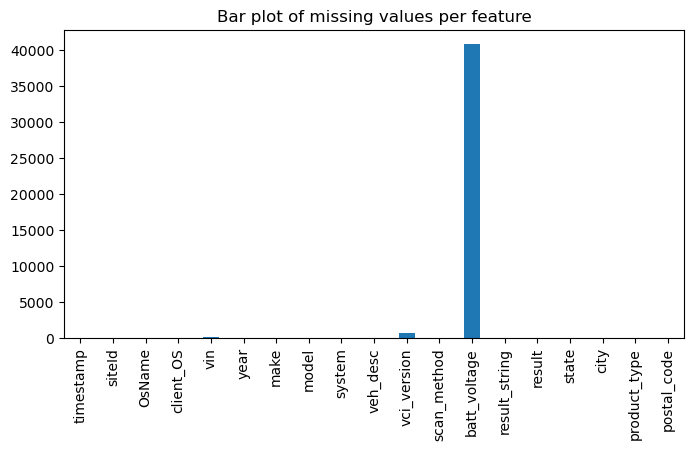

In [233]:
# Check for missing values. Note: battery voltage was only recently added to the data collection. This explains the high percentage of missing values.
diag_usage_df.isnull().sum().plot(kind='bar', figsize=(8, 4))
plt.title('Bar plot of missing values per feature')
plt.show()

In [234]:
#find features with high percentage of missing values
(diag_usage_df.isna().sum() / len(diag_usage_df)) * 100

timestamp         0.000000
siteId            0.000000
OsName            0.000000
client_OS         0.000000
vin               0.023042
year              0.000000
make              0.000000
model             0.000000
system            0.000000
veh_desc          0.000000
vci_version       0.398058
scan_method       0.000000
batt_voltage     23.487122
result_string     0.000000
result            0.000000
state             0.000000
city              0.000000
product_type      0.000000
postal_code       0.000000
dtype: float64

### Remove records with invalid batt_voltage values and use imputation to fill missing values

In [235]:
diag_usage_df = diag_usage_df[~diag_usage_df['batt_voltage'].str.contains(',', na=False)]
diag_usage_df = diag_usage_df[~diag_usage_df['batt_voltage'].str.lower().str.contains('no data', case=False, na=False)]
diag_usage_df = diag_usage_df[(diag_usage_df['batt_voltage'].astype(float) >= 0) | (diag_usage_df['batt_voltage'].isna())]

In [236]:
#convert the batt_voltage column to float
diag_usage_df['batt_voltage'] = diag_usage_df['batt_voltage'].apply(lambda x: round(float(x), 2))

In [238]:
diag_usage_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172706 entries, 0 to 190262
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   timestamp      172706 non-null  datetime64[ns]
 1   siteId         172706 non-null  int32         
 2   OsName         172706 non-null  object        
 3   client_OS      172706 non-null  object        
 4   vin            172666 non-null  object        
 5   year           172706 non-null  int32         
 6   make           172706 non-null  object        
 7   model          172706 non-null  object        
 8   system         172706 non-null  object        
 9   veh_desc       172706 non-null  object        
 10  vci_version    172117 non-null  object        
 11  scan_method    172706 non-null  object        
 12  batt_voltage   131934 non-null  float64       
 13  result_string  172706 non-null  object        
 14  result         172706 non-null  object        
 15  state

In [239]:
#find the median of "batt_voltage" column excluding zero values - a zero value indicates missing data replace with np.nan
median_batt_voltage = diag_usage_df.loc[diag_usage_df['batt_voltage'] != np.nan, 'batt_voltage'].median()
print("Median of batt_voltage:", median_batt_voltage)

Median of batt_voltage: 12.16


In [240]:
# replace missing values with the median value
diag_usage_df['batt_voltage'].fillna(median_batt_voltage, inplace=True)

In [241]:
diag_usage_df.describe().round(2).T

,count,mean,min,25%,50%,75%,max,std
timestamp,172706,2024-12-05 14:53:58.925091072,2024-10-01 20:24:02.463000,2024-11-01 18:30:38.929999872,2024-12-04 16:20:36.955500032,2025-01-09 19:15:20.588499968,2025-02-09 16:28:29.957000,NaN
siteId,172706.0,467345.33,10388.0,258509.0,482188.0,667934.0,888822.0,243345.37
year,172706.0,2017.38,1994.0,2015.0,2018.0,2021.0,2025.0,5.27
batt_voltage,172706.0,12.56,1.48,11.75,12.16,13.78,22.69,1.16


In [242]:
systems = diag_usage_df['system'].unique()
print(f"Number of unique systems: {len(systems)}")

Number of unique systems: 894


### There are almost 900 unique systems in the dataset. 
map OEM specific system names to less broad system categories. 

In [243]:
system_category_mapping = {
    'Enhanced Powertrain': [
        'enhanced powertrain', 'digital motor', 'dme', 'powertrain', 'engine control', 'engine', 'digital diesel', 'drivetrain', 'hybrid control', 'ima motor system'
    ],	
	'Fuel Pump': [
        'fuel pump'
    ],
	'Drive Motor Control System': [
        'motor generator', 'drive motor control module', 'traction energy', 'drive motor', 'motor control', 'drive motor control', 'traction electric machine electronics'
    ],    
    'Telematics': [
        'telematic', 'wireless'
    ],  
    'Airbag Control System': [
        'supplemental inflatable restraint', 'supplemental restraint', 'airbag control module', 'srs-airbag', 'srs can',
        'sir', 'airbag', 'inflatable restraint', 'restraint system', 'srs', 'airbag module', 'active safety', 'pre collision', 'precollision'
    ],
	'ADAS': [
        'radar', 'adas', 'driver assist', 'blind spot', 'adaptive cruise', 'rear camera', 'front camera', 'object detection', 'object sensor', 'cruise control', 'lane camera', 'frontview camera', 'sonar', 'acoustic', 'pedestrian protection',
        'lane change', 'lane departure', 'side obstacle', 'side optical detection', 'collision avoidance assist', 'emergency braking system', 'reverse automatic braking', 'camera module', 'lane change', 'parktronics', 'camera system'
    ],
	'Infotainment System': [
        'instrument cluster', 'ipc', 'instrument control', 'instrument panel', 'sync', 'information control', 'information display', 'information center', 'information module', 'head unit', 'headunit', 'hands free'
    ],
	'Power Steering System' : [
        'power steering', 'eps', 'steering assist', 'steering angle', 'steering column', 'sas control', 'steering wheel'
    ],
    'Transmission Control System': [
        'transmission control', 'tcm', 'transmission', 'cvt', 'transfer case', 'differential', 'transaxle', 'transmission control module', 'final drive', 'gear shift', 'e-shifter', '4x4', 'four wheel', '4wd', '4wal', 'gear select', 'all-wheel'
    ],    
    'Body Control System': [
        'body control', 'bcm', 'door', 'main body', 'seat memory', 'seat module', 'body domain', 'body basic', 'central elect', 'cabin compartment', 'chime alarm', 'car access', 'keyless entry', 'keyless start', 'keyless access', 'keyless ignition', 'keyless vehicle', 'keyless', 'sliding roof'
    ],    
    'Chassis Control System': [
        'chassis control module', 'chassis control', 'suspension', 'tailgate', 'liftgate', 'tail gate', 'lift gate'
    ],    
    'HVAC Control System': [
        'hvac control module', 'hvac', 'air conditioning', 'climate control', 'ccm', 'heater', 'climate', 'heating and ac'
    ],
    'Fuel System': [
        'fuel pump control', 'fuel system', 'fuel control'
    ],
    'Gateway': [
        'gateway', 'vehicle communication interface', 'vehicle system interface'
    ],
    'Crash Safety System': [
        'safety belt', 'crash safety', 'crash', 'restraint', 'tensioning', 'tensioner'
    ],
	'Park Assist': [
        'park assist', 'parking', 'park aid', 'parktronics', 'parktronic system'
    ],
	'TPMS': [
        'tire pressure', 'tpms', 'tpws', 'tyre pressure'
    ],
	'Theft Deterrent': [
        'theft', 'smart key', 'immobilizer', 'security', 'passlock'
    ],
	'Occupant Sensing System': [
        'occ', 'occupant', 'ocs', 'seat weight sensor', 'passenger presence', 'ppm', 'weight sensing system', 'weight control'
    ],
	'Accessory Power System': [
        'dc dc converter', 'ddw', 'accessory power', 'apm'
    ],
	'Battery Management System': [
        'battery energy', 'battery control', 'becm', 'battery system', 'hv batt', 'battery monitoring', 'battery pack control module'
    ],
	'Head Lamp Control System': [
        'head lamp', 'headlight', 'headlamp'
    ],
    'Radio Control System': [
        'radio', 'audio', 'entertainment', 'rcm', 'amplifier', 'sound system'
    ],
    'General Electronics System': [
        'general electronics', 'gem', 'electrical machine'
    ],
    'Braking System': [
        'anti-lock brake', 'abs', 'tcs', 'brake control', 'brake', 'dynamic stablity', 'antilock brakes', 'brake system', 'esc', 'brake epb', 'stability', 'vehicle dynamics', 'esp', 'asc'
    ]
}


In [244]:
def map_system_to_category(system_name):
    # Iterate over the system category mapping dictionary and return the common system name if found
    for key, values in system_category_mapping.items():
        if any(value in system_name.lower() for value in values):
            return key
    return 'other'  # If no mapping is found, return the original name

In [245]:
diag_usage_df['system_category'] = diag_usage_df['system'].apply(map_system_to_category)
diag_usage_df.sample(5)

,timestamp,siteId,OsName,client_OS,vin,year,make,model,system,veh_desc,vci_version,scan_method,batt_voltage,result_string,result,state,city,product_type,postal_code,system_category
9710,2024-12-18 18:32:55.539,269477,iPadOS,iPadOS 17.6.1,1FT8W3DT4ME,2021,Ford,PowerStroke,Enhanced Powertrain CAN,2021 Ford PowerStroke 6.7L Enhanced Powertrain...,22.3.2439.2,quick_scan,12.16,Successfully connected to vehicle,success,IN,Carmel,COLLISION,46032-1313,Enhanced Powertrain
106130,2024-10-02 18:28:06.910,100613,Android,Android 11,4T1BF1FK3CU,2012,Toyota,Camry,Enhanced Powertrain CAN,2012 Toyota Camry Enhanced Powertrain CAN,22.1.2418.1,quick_scan,12.16,Successfully connected to vehicle,success,SC,GREENWOOD,COLLISION,29649-9013,Enhanced Powertrain
143336,2025-01-29 23:22:00.643,353692,Android,Android 12,1FT7W2BT2HE,2017,Ford,PowerStroke,Enhanced Powertrain CAN,2017 Ford PowerStroke 6.7L Enhanced Powertrain...,22.3.2439.2,manual scan,14.33,Successfully connected to vehicle,success,LA,DRY PRONG,REPAIR,71423-3983,Enhanced Powertrain
16653,2024-12-18 15:36:51.879,510965,Android,Android 10,1C4RJKET3P8,2023,Jeep,Grand,Enhanced Powertrain,2023 Jeep Grand Cherokee L Enhanced Powertrain,22.3.2439.2,manual scan,11.43,<div>Communications could not be established w...,failed,ON,OTTAWA,COLLISION,K2J 6H8,Enhanced Powertrain
115681,2024-10-10 16:41:38.477,183826,Android,Android 8.1.0,1GNKVGKD2GJ,2016,Chevrolet,Traverse,Enhanced Powertrain,2016 Chevrolet Traverse Enhanced Powertrain,22.1.2418.1,quick_scan,12.16,Successfully connected to vehicle,success,MN,FOLEY,COLLISION,56329-4609,Enhanced Powertrain


In [246]:
#Determine the percentage of each system category - vast majority of systems are in the 'Enhanced Powertrain' category
system_counts_df = diag_usage_df['system_category']
total_records = system_counts_df.shape[0]
system_counts = system_counts_df.value_counts()
system_counts_percent = system_counts / total_records * 100
system_counts_percent

system_category
Enhanced Powertrain            95.477864
Braking System                  1.394277
Airbag Control System           1.030074
Transmission Control System     0.412840
Body Control System             0.270402
Crash Safety System             0.235082
Occupant Sensing System         0.198603
TPMS                            0.180075
ADAS                            0.140702
other                           0.125647
Power Steering System           0.074114
HVAC Control System             0.067166
Infotainment System             0.057323
Drive Motor Control System      0.052112
Fuel Pump                       0.046901
Radio Control System            0.040531
Park Assist                     0.033004
Chassis Control System          0.031846
General Electronics System      0.029530
Theft Deterrent                 0.026635
Gateway                         0.023161
Battery Management System       0.019108
Head Lamp Control System        0.013317
Telematics                      0.010422


In [247]:
#Determine the percentage of each system category excluding the enhanced powertrain systems
system_counts_df = diag_usage_df[diag_usage_df['system_category'] != 'Enhanced Powertrain']['system_category']
total_records = system_counts_df.shape[0]
system_counts = system_counts_df.value_counts()
system_counts_percent = system_counts / total_records * 100
system_counts_percent
#total_records

system_category
Braking System                 30.832266
Airbag Control System          22.778489
Transmission Control System     9.129321
Body Control System             5.979513
Crash Safety System             5.198464
Occupant Sensing System         4.391805
TPMS                            3.982074
ADAS                            3.111396
other                           2.778489
Power Steering System           1.638924
HVAC Control System             1.485275
Infotainment System             1.267606
Drive Motor Control System      1.152369
Fuel Pump                       1.037132
Radio Control System            0.896287
Park Assist                     0.729834
Chassis Control System          0.704225
General Electronics System      0.653009
Theft Deterrent                 0.588988
Gateway                         0.512164
Battery Management System       0.422535
Head Lamp Control System        0.294494
Telematics                      0.230474
Fuel System                     0.153649


In [248]:
#Change result from success/failed to 1/0
diag_usage_df['result'] = diag_usage_df['result'].map({'success': 1, 'failed': 0})
diag_usage_df['year'] = diag_usage_df['year'].astype(str)
#remove vci_version with text demo
diag_usage_df = diag_usage_df[~diag_usage_df['vci_version'].str.lower().str.contains('demo', na=False)]
diag_usage_df = diag_usage_df[~diag_usage_df['vci_version'].str.lower().str.contains('dev', na=False)]

In [249]:
#drop result_string column
diag_usage_df = diag_usage_df.drop(columns=['result_string'])

In [250]:
#remove years 1994-1996 as they are not offcially supported by the tool
diag_usage_df = diag_usage_df[~diag_usage_df['year'].isin(['1994', '1995', '1996'])]

In [251]:
diag_usage_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 171527 entries, 0 to 190262
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   timestamp        171527 non-null  datetime64[ns]
 1   siteId           171527 non-null  int32         
 2   OsName           171527 non-null  object        
 3   client_OS        171527 non-null  object        
 4   vin              171490 non-null  object        
 5   year             171527 non-null  object        
 6   make             171527 non-null  object        
 7   model            171527 non-null  object        
 8   system           171527 non-null  object        
 9   veh_desc         171527 non-null  object        
 10  vci_version      170946 non-null  object        
 11  scan_method      171527 non-null  object        
 12  batt_voltage     171527 non-null  float64       
 13  result           171527 non-null  int64         
 14  state            171527 n

### Fill missing location information with 'unknown'

In [252]:
attributes = ['state', 'city', 'product_type', 'postal_code']
for attribute in attributes:
    num_unknown = diag_usage_df[attribute].str.lower().str.contains('unknown', na=False).sum()
    unknown_percent = num_unknown / diag_usage_df.shape[0] * 100
    print(f'Percentage of unknown values for {attribute}: {unknown_percent} num unknown: {num_unknown}')    

Percentage of unknown values for state: 9.273758650241653 num unknown: 15907
Percentage of unknown values for city: 9.273758650241653 num unknown: 15907
Percentage of unknown values for product_type: 9.273758650241653 num unknown: 15907
Percentage of unknown values for postal_code: 9.273758650241653 num unknown: 15907


In [253]:
#uncomment out to save cleaned data to excel file
#diag_usage_df.to_excel('DiagUsage_Cleaned.xlsx', index=False)

**Data Cleaning Summary:**
<div style="margin-left: 20px;">
  <ul>
    <li>Un-needed features such as 'billable status' were removed</li>
    <li>Imputation was used to fill missing battery voltage entries. The mean was used as a replacement. Invalid battery voltage entries were remove</li>
    <li>Multi-word vehicle make entries were combined to a single word (Mercedes Benz -> Mercedes-Benz)</li>
    <li>Invalid vehicle make entries were removed</li>
    <li>891 unique vehicle systems accross all makes were normalized into standard system category naming</li>
    <li>Vehicle scans using products 'demo mode' were removed</li>
  </ul>
</div> 

**Data Dictionary:**:
<div style="margin-left: 20px;">
  <ul>
    <li><strong>siteId</strong>&nbsp;&nbsp;Anonymized customer Id for shop performing the scan</li>
    <li><strong>vin</strong>&nbsp;&nbsp;In addition to make, model, and year, the VIN encodes details on body style, engine type, and features to distinguish trim levels</li>
    <li><strong>year</strong>&nbsp;&nbsp;Production year of the vehicle for the scan tool connection attempt</li>
    <li><strong>make</strong>&nbsp;&nbsp;Manufacturer or brand of vehicle for the scan tool connection attempt</li>
    <li><strong>model</strong>&nbsp;&nbsp;Product line or design of vehicle for the scan tool connection attempt</li>
    <li><strong>system_category</strong>&nbsp;&nbsp;Represents the ECU (Electronic Control Unit), which is the endpoint of communications in the vehicle</li>
    <li><strong>veh_desc</strong>&nbsp;&nbsp;Concatenation of vehicles make, model and year. Used in visualizations</li>
    <li><strong>vci_version</strong>&nbsp;&nbsp;Software version level of the diagnostics scan tool at time of the scan</li>
    <li><strong>scan_method</strong>&nbsp;&nbsp;Connection method used for connection attempt (manual_scan or quick_scan)</li>
    <li><strong>batt_voltage</strong>&nbsp;&nbsp;Low battery voltage may be a cause of communications failures</li>
    <li><strong>product_type</strong>&nbsp;&nbsp;Customer type Repair or Collision</li>
    <li><strong>result</strong>&nbsp;&nbsp;0 - comm attempt failed. 1 - comm attempt was successful</li>
  </ul>
</div> 